In [1]:
from Recommender_Model import Recommender_Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#Rui's code to preprae for training the model
df = pd.read_csv("C:/Users/easht/Documents/CS 673/Movie Database/merged.csv")
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes
# print(df.head())
user_id = 4
# Get user_ids , movie_ids, and ratings as separate arrays
user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
unwatched_movies_ids = df[df.userId != user_id]['new_movie_id'].values
ratings = df["rating"].values
movie_titles = df["title"].values
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes
new_movie_ids = df["new_movie_id"].values
movies = {}
for i in range(len(new_movie_ids)):
    movies[new_movie_ids[i]] = movie_titles[i]

# Get number of users and number of movies
uNum = len(set(user_ids))
mNum = len(set(movie_ids))
# Set embedding dimension
K = 50

# Shuffle and split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
# 4:1 train-test ratio
brk = int(0.8 * len(user_ids))
user_train = user_ids[:brk]
movie_train = movie_ids[:brk]
ratings_train = ratings[:brk]

user_test = user_ids[brk:]
movie_test = movie_ids[brk:]
ratings_test = ratings[brk:]
# Center the ratings (Normalization without dividing standard deviation)
mRatings = np.mean(ratings)
ratings_train -= mRatings
ratings_test -= mRatings

user2user_encoded = {user_ids[i]: i for i in range(len(user_ids))}
user_encoded2user = {i: user_ids[i] for i in range(len(user_ids))}
movie2movie_encoded = {movie_ids[i]: i for i in range(len(movie_ids))}
movie_encoded2movie = {i: movie_ids[i] for i in range(len(movie_ids))}

# unwatched_movies_ids = get_unwatched_movies_django(user_id)
unwatched_movie_index = [[movie2movie_encoded[x]] for x in unwatched_movies_ids]
user_encoder = user2user_encoded[user_id]
user_movie_array = np.hstack(([[user_encoder]] * len(unwatched_movies_ids), unwatched_movie_index))

In [3]:
#Rui's code to initialize the model
model = Recommender_Model(K, uNum, mNum)
model.compile(optimizer=SGD(learning_rate=1e-2, momentum=3e-1),
                  loss="mse")

In [4]:
#Rui's code to set model parameters

# Create a scheduler to change the learning rate
def schedule(epoch, lr):
    if epoch >= 20:
        return 1e-3
    return 1e-2
    
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# Fit the model the data is an array of users and movies

In [5]:
#Rui's code to train the model (takes 8 hours on Eric' system)
r = model.fit([user_train, movie_train], ratings_train, batch_size=1024, epochs=25,
                  validation_data=([user_test, movie_test], ratings_test), callbacks=[callback, scheduler])

Epoch 1/25
15626/15626 [==============================] - 1186s 76ms/step - loss: 0.8306 - val_loss: 0.7591 - lr: 0.0100
Epoch 2/25
15626/15626 [==============================] - 1188s 76ms/step - loss: 0.7398 - val_loss: 0.7377 - lr: 0.0100
Epoch 3/25
15626/15626 [==============================] - 1190s 76ms/step - loss: 0.7219 - val_loss: 0.7245 - lr: 0.0100
Epoch 4/25
15626/15626 [==============================] - 1177s 75ms/step - loss: 0.7040 - val_loss: 0.7093 - lr: 0.0100
Epoch 5/25
15626/15626 [==============================] - 1182s 76ms/step - loss: 0.6909 - val_loss: 0.7001 - lr: 0.0100
Epoch 6/25
15626/15626 [==============================] - 1182s 76ms/step - loss: 0.6814 - val_loss: 0.6919 - lr: 0.0100
Epoch 7/25
15626/15626 [==============================] - 1184s 76ms/step - loss: 0.6720 - val_loss: 0.6924 - lr: 0.0100
Epoch 8/25
15626/15626 [==============================] - 1187s 76ms/step - loss: 0.6626 - val_loss: 0.6897 - lr: 0.0100
Epoch 9/25
15626/15626 [========

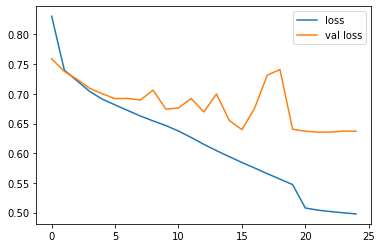

In [6]:
#Shows model performance over the time it is trained. We want to end up with a loss < .6
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [7]:
model.summary()

Model: "recommender__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1)                 8419803   
                                                                 
Total params: 8,419,803
Trainable params: 8,419,803
Non-trainable params: 0
_________________________________________________________________


In [44]:
#When I try to save and load the model I get a useless UserObject type
model.save("New_model")
model2 = tf.saved_model.load("New_Model")
type(model2)


INFO:tensorflow:Assets written to: New_model\assets


tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [45]:
#The original model I made is still the correct type (Recommender_Model)
type(model)

Recommender_Model.Recommender_Model

In [56]:
#Rui's method to recommend movies based on a user id 

def recommend(user_id):
    user2user_encoded = {user_ids[i]: i for i in range(len(user_ids))}
    user_encoded2user = {i: user_ids[i] for i in range(len(user_ids))}
    movie2movie_encoded = {new_movie_ids[i]: i for i in range(len(new_movie_ids))}
    movie_encoded2movie = {i: new_movie_ids[i] for i in range(len(new_movie_ids))}

    unwatched_movies_ids = df[df.userId != user_id]['new_movie_id'].values
    unwatched_movies_ids_set = set(unwatched_movies_ids)
    unwatched_movie_index = [[movie2movie_encoded[x]] for x in unwatched_movies_ids_set]
    user_encoder = user2user_encoded[user_id]
    # user_movie_array = np.hstack(([[user_encoder]] * len(unwatched_movies_ids_set), unwatched_movie_index))
    user = np.array([user_id for i in range(len(unwatched_movies_ids_set))])
    unwatched_movies_ids_set = np.array(list(unwatched_movies_ids_set))
    predicted_ratings = model.predict([user, unwatched_movies_ids_set]).flatten()
    top_N_rating_indices = predicted_ratings.argsort()[:top_N][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(unwatched_movie_index[x][0]) for x in top_N_rating_indices]

    # movies = extract_movie_data()
    recommended_movies = [movies[i] for i in recommended_movie_ids]
    print (recommended_movies)
    #return recommended_movie_ids

In [46]:
#Rui's code to prepare to run the recommend method 
top_N = 30

df = pd.read_csv("C:/Users/easht/Documents/CS 673/Movie Database/merged.csv")
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes
# print(df.head())
user_id = 4
# Get user_ids , movie_ids, and ratings as separate arrays
user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
unwatched_movies_ids = df[df.userId != user_id]['new_movie_id'].values
ratings = df["rating"].values
movie_titles = df["title"].values
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes
new_movie_ids = df["new_movie_id"].values
movies = {}
for i in range(len(new_movie_ids)):
        movies[new_movie_ids[i]] = movie_titles[i]


In [57]:
recommend(1)

836/836 [==============================] - 1s 673us/step
['Howling III: The Marsupials (1987)', 'Vampires Suck (2010)', 'Beverly Hills Chihuahua 2 (2011)', 'Retro Puppet Master (Puppet Master 7) (1999)', 'Brown Bunny, The (2003)', "Justin Bieber's Believe (2013)", "It's Pat (1994)", 'Mega Shark vs. Giant Octopus (2009)', "Seed of Chucky (Child's Play 5) (2004)", 'Prom Night IV: Deliver Us From Evil (1992)', 'Carnosaur 3: Primal Species (1996)', 'Faces of Death 5 (1996)', 'Ernest in the Army (1998)', 'Dance Flick (2009)', 'Son of the Mask (2005)', 'Disaster Movie (2008)', 'Pokémon 3: The Movie (2001)', 'Gigli (2003)', 'Black Christmas (2006)', 'Zombie Strippers! (2008)', 'Horrors of Spider Island (Ein Toter Hing im Netz) (1960)', 'SuperBabies: Baby Geniuses 2 (2004)', 'Time Walker (a.k.a. Being From Another Planet) (1982)', 'Glitter (2001)', 'Hip Hop Witch, Da (2000)', 'Bratz: The Movie (2007)', 'Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)', 'House of the Dead, The (2003)', 'Pok

In [58]:
recommend(7)

836/836 [==============================] - 1s 698us/step
['Giant Spider Invasion, The (1975)', 'Yu-Gi-Oh! (2004)', 'Legion of the Dead (2001)', 'Epic Movie (2007)', 'Hercules in New York (1970)', 'Ernest Goes to Africa (1997)', 'Meet the Spartans (2008)', 'Spy Kids: All the Time in the World in 4D (2011)', 'Witless Protection (2008)', 'Ernest in the Army (1998)', 'War of the Worlds 2: The Next Wave (2008)', 'Glitter (2001)', 'Carnosaur 2 (1995)', 'Faces of Death 4 (1990)', 'Dance Flick (2009)', 'Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)', "God's Not Dead (2014)", 'Faces of Death 5 (1996)', 'Faces of Death: Fact or Fiction? (1999)', 'Carnosaur 3: Primal Species (1996)', 'Son of the Mask (2005)', 'Faces of Death 6 (1996)', 'From Justin to Kelly (2003)', 'Beverly Hills Chihuahua 2 (2011)', 'House of the Dead, The (2003)', 'Hip Hop Witch, Da (2000)', 'Bratz: The Movie (2007)', 'Pokémon Heroes (2003)', 'SuperBabies: Baby Geniuses 2 (2004)', 'Disaster Movie (2008)']


In [17]:
recommend(10)

836/836 [==============================] - 1s 803us/step
['Driller Killer, The (1979)', 'Farewell, The (Abschied - Brechts letzter Sommer) (2000)', 'Pokémon Heroes (2003)', 'Private Parts (1972)', 'Dance Flick (2009)', 'Anaconda III (2008)', 'Against the Dark (2009)', 'Kids of the Round Table (1995)', 'Gigli (2003)', 'Pink Flamingos (1972)', '3 Ninjas: High Noon On Mega Mountain (1998)', 'Attack of the Killer Tomatoes! (1978)', 'War of the Worlds 2: The Next Wave (2008)', 'Texas Chainsaw Massacre 2, The (1986)', 'Disaster Movie (2008)', 'House of the Dead, The (2003)', 'Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)', 'Beverly Hills Chihuahua 2 (2011)', "Barney's Great Adventure (1998)", 'Adventures of Sharkboy and Lavagirl 3-D, The (2005)', "Justin Bieber's Believe (2013)", 'Turbo: A Power Rangers Movie (1997)', 'Toxic Avenger, The (1985)', 'Son of the Mask (2005)', 'Hip Hop Witch, Da (2000)', 'Time Walker (a.k.a. Being From Another Planet) (1982)', 'From Justin to Kelly (2003)',

[7461,
 4954,
 6266,
 12987,
 13758,
 19223,
 13453,
 55,
 6477,
 2276,
 1677,
 2079,
 13259,
 2375,
 12942,
 6762,
 5573,
 17508,
 1746,
 10143,
 22343,
 1452,
 3602,
 9754,
 7170,
 6043,
 6373,
 12003,
 9414,
 8176]

In [18]:
recommend(100)

836/836 [==============================] - 1s 679us/step
['Ernest Goes to Africa (1997)', 'Date Movie (2006)', 'Faces of Death 6 (1996)', 'Faces of Death 5 (1996)', 'Carnosaur 2 (1995)', 'Grudge 3, The (2009)', 'Home Alone 4 (2002)', 'Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)', 'Meet the Spartans (2008)', 'Beverly Hills Chihuahua 2 (2011)', 'Yu-Gi-Oh! (2004)', 'Kazaam (1996)', 'Witless Protection (2008)', 'Alone in the Dark (2005)', 'Carnosaur 3: Primal Species (1996)', 'Spy Kids: All the Time in the World in 4D (2011)', 'House of the Dead, The (2003)', 'Glitter (2001)', 'War of the Worlds 2: The Next Wave (2008)', "God's Not Dead (2014)", 'Epic Movie (2007)', 'Gigli (2003)', "Barney's Great Adventure (1998)", 'Hip Hop Witch, Da (2000)', 'Pokémon Heroes (2003)', 'From Justin to Kelly (2003)', 'Son of the Mask (2005)', 'Bratz: The Movie (2007)', 'Disaster Movie (2008)', 'SuperBabies: Baby Geniuses 2 (2004)']


[5548,
 10847,
 5640,
 5639,
 3482,
 13397,
 16652,
 5573,
 12392,
 17508,
 8128,
 797,
 12457,
 9695,
 3483,
 17667,
 6762,
 4679,
 13259,
 23098,
 11594,
 6477,
 1746,
 7170,
 6266,
 6373,
 9754,
 12003,
 12942,
 8176]

In [59]:
recommend(1000)

836/836 [==============================] - 1s 651us/step
['Carnosaur 3: Primal Species (1996)', 'Crossroads (2002)', 'Extreme Ops (2002)', 'Left Behind: The Movie (2000)', 'Yu-Gi-Oh! (2004)', 'Date Movie (2006)', "God's Not Dead (2014)", 'Anaconda III (2008)', 'Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)', 'Alone in the Dark (2005)', 'Gigli (2003)', 'Agent Cody Banks 2: Destination London (2004)', 'House of the Dead, The (2003)', 'Turbo: A Power Rangers Movie (1997)', 'Home Alone 4 (2002)', 'Beverly Hills Chihuahua 2 (2011)', 'Little Man (2006)', 'Spy Kids: All the Time in the World in 4D (2011)', 'Witless Protection (2008)', "Barney's Great Adventure (1998)", 'Epic Movie (2007)', 'Pokémon Heroes (2003)', 'Glitter (2001)', 'Son of the Mask (2005)', 'Disaster Movie (2008)', 'War of the Worlds 2: The Next Wave (2008)', 'Hip Hop Witch, Da (2000)', 'Bratz: The Movie (2007)', 'From Justin to Kelly (2003)', 'SuperBabies: Baby Geniuses 2 (2004)']
